# Module 4: Deep Learning
# Sprint 2: Natural Language Processing
## Toxic Comment Classification Challenge

---

**Dataset**:
The dataset consists of a large number of Wikipedia comments, labeled by human raters for toxic behavior. The train dataset contains 159K labeled comments, and there are 63K in the test dataset.

The comments are categorized under the following types of toxicity: toxic, severe_toxic, obscene, threat, insult, and identity_hate.

---

**Goal**:
The aim is to develop a model that predicts the probability of each type of toxicity for every comment. The evaluation metric is the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs for each predicted column.

---

**Project Outline**:
1. Loading the data from Kaggle.
2. Explanatory Data Analysis (EDA).
3. Classification using a pre-trained Roberta model.
4. Evaluation using the ROC-AUC score.
5. Summary.

---

## Data import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Tuple, List, Dict
from google.colab import files
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from IPython.display import clear_output

!pip install tqdm
from tqdm import tqdm

!pip install torch transformers
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

import torch
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
from torch.nn.functional import _Loss
from torch.optim import AdamW, Optimizer
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
clear_output()

In [ ]:
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

!unzip jigsaw-toxic-comment-classification-challenge.zip
!unzip sample_submission.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip
!unzip test_labels.csv.zip

clear_output()

Loading the training dataset:

In [ ]:
df = pd.read_csv('train.csv')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
condition = (df[labels] == 0).all(axis=1)
toxic_df = df[~condition].copy()
non_toxic_df = df[condition].copy()
df['non_toxic'] = np.where(condition, 1, 0)
print(df.shape)
df.head(3)

(159571, 9)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1


A new column named 'non-toxic' is created to mark comments where all the labels have a value of 0.

In [ ]:
def get_test_data() -> pd.DataFrame:
  """
  Loads and merges test data from CSV files.
  """
  test_df = pd.read_csv('test.csv')
  test_labels_df = pd.read_csv('test_labels.csv')

  test_labels_df = test_labels_df[test_labels_df[labels].ne(-1).any(axis=1)]
  test_df = test_df[test_df['id'].isin(test_labels_df['id'])]
  test_df = test_df.merge(test_labels_df, on='id')

  return test_df

test_df = get_test_data()
condition = (test_df[labels] == 0).all(axis=1)
test_df['non_toxic'] = np.where(condition, 1, 0)
print(test_df.shape)
test_df.head(3)

(63978, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0


The test dataset is imported, and test comments are matched with their labels. Additionally, a 'non-toxic' label is created.

## EDA

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


Do comments labeled as 'severe_toxic' also automatically fall under the 'toxic' label?

In [ ]:
df[(df['toxic'] != 1) & (df['severe_toxic'] == 1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic


Yes. The empty table shows that when a comment is labeled 'severe_toxic', it is also labeled as 'toxic'.


In [ ]:
def compute_stats(dataframes: List[pd.DataFrame], labels: List[str]) -> pd.DataFrame:
    """
    Computes statistics on given dataframes for textual analysis.

    Args:
        dataframes (List[DataFrame]): List of dataframes containing the 'comment_text' column.
        labels (List[str]): Names of the labels corresponding to each dataframe.

    Returns:
        DataFrame: Contains statistics such as comment counts, average lengths,
                   percentage of capital letters, and percentage of exclamation marks.
    """
    label_names = []
    comment_counts = []
    comment_percs = []
    avg_lengths = []
    capital_letters_perc = []
    exclamation_percs = []

    total_comments = sum([len(df) for df in dataframes])
    for i, temp_df in enumerate(dataframes):
        t = np.round(temp_df['comment_text'].str.len().mean(), 1)

        label_names.append(labels[i])
        comment_count = len(temp_df)
        comment_counts.append(comment_count)
        comment_percs.append(np.round((comment_count/total_comments) * 100, 1))
        avg_lengths.append(t)

        t1 = temp_df['comment_text'].str.count(r'[A-Z]').mean()
        t2 = temp_df['comment_text'].str.count(r'[a-z]').mean()
        capital_letters_perc.append(np.round(t1/t2*100,1) if t2 != 0 else 0)

        excl_marks_count = temp_df['comment_text'].str.count(r'!').mean()
        exclamation_percs.append(np.round((excl_marks_count/t) * 100, 1) if t != 0 else 0)

    result = pd.DataFrame({
        'Label': label_names,
        'Number of Comments': comment_counts,
        'Percentage of Comments': comment_percs,
        'Average Length': avg_lengths,
        'Capital Letters %': capital_letters_perc,
        'Exclamation Marks %': exclamation_percs
    })
    return result

Looking at toxic and non-toxic comments:

In [ ]:
data = [non_toxic_df, toxic_df]
data_labels = ['non toxic', 'toxic']
result = compute_stats(data, data_labels)
cols = ['Percentage of Comments', 'Capital Letters %', 'Exclamation Marks %']
result.style.format(precision=1).background_gradient(cmap='PuBu', vmin=0, vmax=50,
                                                     subset=cols)

,Label,Number of Comments,Percentage of Comments,Average Length,Capital Letters %,Exclamation Marks %
0,non toxic,143346,89.8,404.3,4.8,0.1
1,toxic,16225,10.2,303.3,22.8,1.1


* Almost 90% of comments are non-toxic.
* Non-toxic comments are, on average, about 100 characters longer.
* Toxic comments contain significantly more capital letters - every fifth letter is capitalized.
* Toxic comments also more frequently contain exclamation marks.

Looking only at the toxic comments:

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_dataframes = [df[df[label] == 1] for label in labels]
result = compute_stats(label_dataframes, labels)
result.style.format(precision=1).background_gradient(cmap='PuBu', vmin=0, vmax=50,
                                                     subset=cols)

,Label,Number of Comments,Percentage of Comments,Average Length,Capital Letters %,Exclamation Marks %
0,toxic,15294,43.6,295.2,24.4,1.2
1,severe_toxic,1595,4.5,453.6,82.7,3.6
2,obscene,8449,24.1,286.8,29.9,1.2
3,threat,478,1.4,307.7,52.5,5.5
4,insult,7877,22.4,277.3,30.3,1.3
5,identity_hate,1405,4.0,308.5,42.9,0.7


* 43% of comments are labeled as 'toxic', followed by 'obscene' at 24% and 'insult' at 22%. Only 1.4% of comments are categorized under the 'threat' label.
* Comments labeled as 'severe_toxicity' are the longest on average, with about 452 characters, while 'insult' comments are the shortest, averaging around 277 characters.
* 'Severe toxic' comments have a notably high percentage of capital letters, making up about 82% of all letters. This is followed by 'threat' comments at 50%. In contrast, 'toxic' comments contain only around 24% capital letters.
* In comments labeled as 'threat', approximately 5% of the characters are exclamation marks.

Creating a correlation heatmap to examine the relationships among the labels:

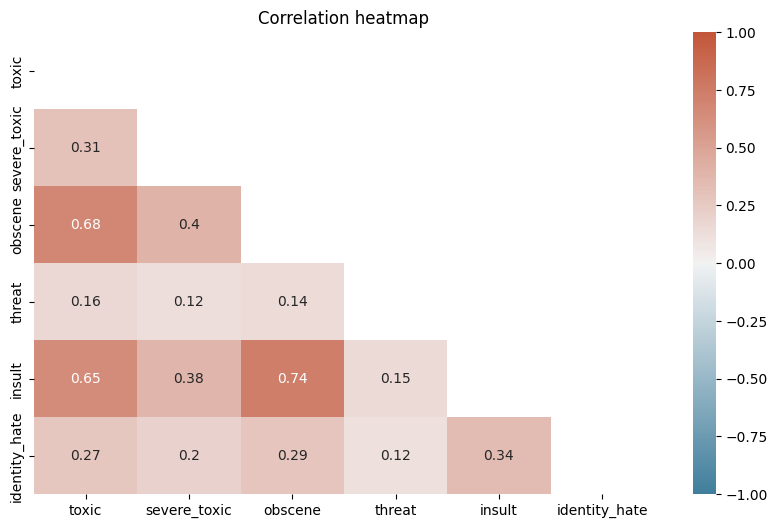

In [ ]:
corr_matrix = df[labels].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=cmap, mask=mask, vmin=-1, vmax=1)
plt.title("Correlation heatmap")
plt.show()

* The highest correlation is between 'obscene' and 'insult' at 0.74.
* Following, 'toxic' and 'obscene' are strongly correlated at 0.67.
* 'Toxic' and 'insult' labels have a correlation of 0.64.

Creating a wordcloud:

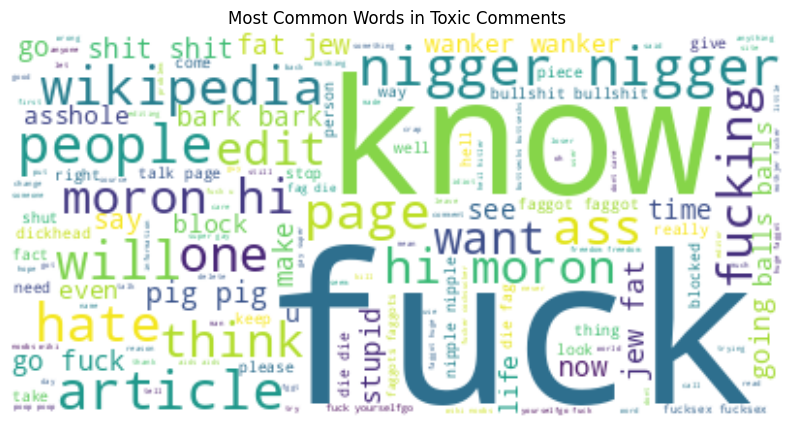

In [ ]:
text = ' '.join(toxic_df['comment_text'].str.lower().tolist())
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Toxic Comments')
plt.show()

By examining the most common words in the toxic comments through the word cloud, we can see a lot of swear words and insults.

## Modeling

For reference, the highest mean column-wise ROC AUC score achieved on Kaggle for this task was 0.988.

In [ ]:
df = pd.read_csv('train.csv')
df = df.sample(n=100000, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(df['comment_text'], df.iloc[:, 2:],
                                                  test_size=0.3, train_size=0.7,
                                                  random_state=0, shuffle=True)

Sampling a subset of the data (using all would consume too much resources) and splitting it into training and testing sets.

### Preprocessing

Tokenization and Dataset Creation
The RoBERTa tokenizer is case-sensitive and effectively handles punctuation, so no preprocessing was required beforehand.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

inputs = tokenizer(X_train.tolist(), return_tensors="pt", padding=True,
                   truncation=True, max_length=512)
labels = torch.tensor(y_train.values)
dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=16)

val_inputs = tokenizer(X_val.tolist(), return_tensors="pt", padding=True,
                       truncation=True, max_length=512)
val_labels = torch.tensor(y_val.values)
val_dataset = TensorDataset(val_inputs.input_ids, val_inputs.attention_mask, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=16)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The code tokenizes the comments, creates label tensors, splits the dataset into training and validation sets, and then loads them into data loaders for batch processing during model training.

In [ ]:
for max_length in [256, 512, 1024]:
    t = np.round(X_train[X_train.str.len() <= max_length].shape[0] / X_train.shape[0] * 100, 2)
    print(f"Length {max_length} covers {t}% of comments.")

Length 256 covers 57.78% of comments.
Length 512 covers 79.32% of comments.
Length 1024 covers 91.87% of comments.


The `max_length` of 512 covers the full length of approximately 80% of the comments. While a `max_length` of 1024 would cover around 90%, it would be too resource-intensive.

### Fine-tuning

In [ ]:
class RobertaForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(RobertaForMultiLabelClassification, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        return logits

The RobertaForMultiLabelClassification class is a modified neural network model that uses the pre-trained RobertaModel for multi-label classification. It changes the original classifier with a linear layer to produce predictions for a specific number of labels. <br>


Below are some functions for training and validation:

In [ ]:
def model_forward(batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                  model: Module, device: torch.device,
                  loss_fn: _Loss) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Processes the input batch through the model, computes the loss, and returns the logits and loss.

    Parameters:
    - batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]): A tuple containing input ids, attention masks, and labels.
    - model (Module): The PyTorch model to forward the input through.
    - device (torch.device): The device to which the data should be moved before forwarding through the model.
    - loss_fn (_Loss): The loss function to compute the loss.

    Returns:
    - Tuple[torch.Tensor, torch.Tensor]: A tuple containing the model's logits and computed loss.
    """
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    logits = model(input_ids, attention_mask=attention_mask)
    loss = loss_fn(logits, labels.float())

    return logits, loss

In [ ]:
def train_one_epoch(dataloader: DataLoader, model: torch.nn.Module, optimizer: Optimizer,
                   scheduler: get_linear_schedule_with_warmup, device: torch.device,
                   loss_fn: torch.nn.Module) -> float:
    """
    Trains the model for one epoch on the provided training dataloader.

    Parameters:
    - dataloader (DataLoader): The DataLoader object that provides batches of training data.
    - model (torch.nn.Module): The PyTorch model to be trained.
    - optimizer (Optimizer): The optimization algorithm used for training.
    - scheduler (get_linear_schedule_with_warmup): The learning rate scheduler.
    - device (torch.device): The device (e.g., 'cuda' or 'cpu') where the model should run.
    - loss_fn (torch.nn.Module): The loss function used to compute the training loss.

    Returns:
    - float: The average training loss over all batches.
    """
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        _, loss = model_forward(batch, model, device, loss_fn)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

In [ ]:
def validate(val_dataloader: DataLoader, model: torch.nn.Module, device: torch.device,
             loss_fn: torch.nn.Module) -> Tuple[float, List[float], List[int]]:
    """
    Validates the model on the provided validation dataloader and computes the loss.

    Parameters:
    - val_dataloader (DataLoader): The DataLoader object that provides batches of validation data.
    - model (torch.nn.Module): The PyTorch model to be validated.
    - device (torch.device): The device (e.g., 'cuda' or 'cpu') where the model should run.
    - loss_fn (torch.nn.Module): The loss function used to compute the validation loss.

    Returns:
    - float: The average validation loss over all batches.
    - List[float]: A list containing the predicted probabilities for each validation example.
    - List[int]: A list containing the true labels for each validation example.
    """
    model.eval()
    val_loss = 0.0
    all_val_probs, all_val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            logits, loss = model_forward(batch, model, device, loss_fn)
            all_val_probs.extend(logits.sigmoid().cpu().numpy())
            all_val_labels.extend(batch[2].cpu().numpy())
            val_loss += loss.item()

    return val_loss / len(val_dataloader), all_val_probs, all_val_labels

In [ ]:
def compute_roc_auc(all_val_probs: List[float], all_val_labels: List[int]) -> Dict[int, float]:
    """
    Computes the ROC AUC score for each label column.

    Parameters:
    - all_val_probs (List[float]): A list of predicted probabilities from the model.
    - all_val_labels (List[int]): A list of true label values.

    Returns:
    - Dict[int, float]: A dictionary where keys are label column indices and values are the computed ROC AUC scores.
    """
    roc_auc_scores = {}
    all_val_probs_np = np.array(all_val_probs)
    all_val_labels_np = np.array(all_val_labels)

    for label_col in range(all_val_labels_np.shape[1]):
        roc_auc = roc_auc_score(all_val_labels_np[:, label_col], all_val_probs_np[:, label_col])
        roc_auc_scores[label_col] = float(f"{roc_auc:.2f}")

    return roc_auc_scores

In [ ]:
model = RobertaForMultiLabelClassification().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(dataloader) * epochs)

The code initializes a multi-label classification model using Roberta, sets up the optimizer with a learning rate, defines the binary cross-entropy with logits loss function, specifies the number of training epochs, and creates a learning rate scheduler.

Training the model for a specified number of epochs, recording the metrics, and saving the model's state with the lowest validation loss:

In [ ]:
train_losses, val_losses, val_roc_aucs = [], [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    avg_train_loss = train_one_epoch(dataloader, model, optimizer, scheduler, device, loss_fn)
    avg_val_loss, all_val_probs, all_val_labels = validate(val_dataloader, model, device, loss_fn)
    roc_auc_scores = compute_roc_auc(all_val_probs, all_val_labels)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_roc_aucs.append(roc_auc_scores)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Epoch {epoch + 1}/{epochs}, "
      f"Training Loss: {avg_train_loss:.4f}, "
      f"Validation Loss: {avg_val_loss:.4f}, "
      f"ROC AUC Score: mean: {np.round(np.mean(list(roc_auc_scores.values())), 3)}; "
      f"{roc_auc_scores}")

Training: 100%|██████████| 4375/4375 [26:11<00:00,  2.78it/s]


Epoch 1/3, Training Loss: 0.0525, Validation Loss: 0.0507, ROC AUC Score: mean: 0.983; {0: 0.98, 1: 0.99, 2: 0.99, 3: 0.97, 4: 0.99, 5: 0.98}


Training: 100%|██████████| 4375/4375 [26:10<00:00,  2.79it/s]


Epoch 2/3, Training Loss: 0.0384, Validation Loss: 0.0418, ROC AUC Score: mean: 0.987; {0: 0.99, 1: 0.99, 2: 0.99, 3: 0.97, 4: 0.99, 5: 0.99}


Training: 100%|██████████| 4375/4375 [26:10<00:00,  2.79it/s]


Epoch 3/3, Training Loss: 0.0293, Validation Loss: 0.0427, ROC AUC Score: mean: 0.987; {0: 0.99, 1: 0.99, 2: 0.99, 3: 0.97, 4: 0.99, 5: 0.99}


 Visualizing the training and validation loss progression across epochs:

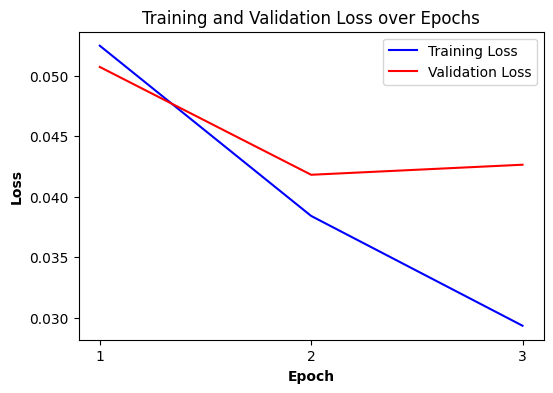

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs+1), train_losses, color='blue', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, color='red', label='Validation Loss')

plt.xticks(range(1, epochs+1))
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Loss', weight='bold')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

### Classification

In [ ]:
test_df = get_test_data()
test_df = test_df.sample(n=50000, random_state=0)

test_inputs = tokenizer(test_df['comment_text'].tolist(), return_tensors="pt",
                        padding=True, truncation=True, max_length=512)
test_labels = torch.tensor(test_df.iloc[:, 2:].values).to(device)
test_inputs = {key: val.to(device) for key, val in test_inputs.items()}

test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
all_probs = []
all_labels = []
for batch in tqdm(test_dataloader, desc="Predicting"):
    input_ids, attention_mask, labels = [t.to(device) for t in batch]

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

all_probs_np = np.array(all_probs)
true_labels_np = np.array(all_labels)

Predicting: 100%|██████████| 1563/1563 [05:39<00:00,  4.60it/s]


A sampled subset of the test data is preprocessed and tokenized, after which it is passed through the trained model to obtain predicted probabilities for each label.

### Evaluation

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
roc_auc_scores = compute_roc_auc(all_probs_np, true_labels_np)

valid_roc_auc_scores = [value for value in roc_auc_scores.values() if value is not None]

for label, score in zip(labels, valid_roc_auc_scores):
    print(f"{label}: {score};")

average_roc_auc = sum(valid_roc_auc_scores) / len(valid_roc_auc_scores)
print("\nAverage ROC AUC:", np.round(average_roc_auc, 3))

toxic: 0.97;
severe_toxic: 0.99;
obscene: 0.98;
threat: 1.0;
insult: 0.98;
identity_hate: 0.99;

Average ROC AUC: 0.985


ROC AUC scores for each label and the overall average:

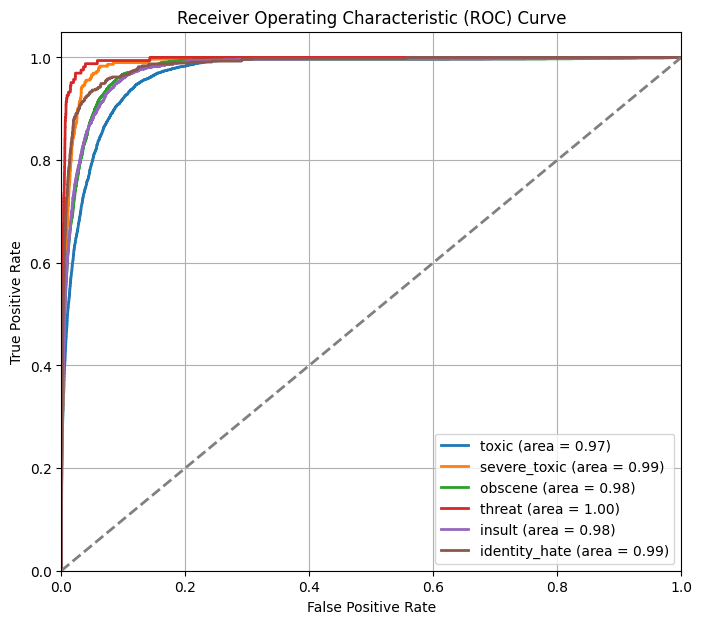

In [ ]:
num_labels = true_labels_np.shape[1]
plt.figure(figsize=(8, 7))

for idx in range(num_labels):
    true_label = true_labels_np[:, idx]
    pred_probs = all_probs_np[:, idx]

    fpr, tpr, thresholds = roc_curve(true_label, pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{labels[idx]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
predicted_labels_np = (all_probs_np > 0.5).astype(int)
report = classification_report(true_labels_np, predicted_labels_np, target_names=labels, zero_division=0)
print(report)

               precision    recall  f1-score   support

        toxic       0.52      0.90      0.66      4733
 severe_toxic       0.35      0.55      0.43       294
      obscene       0.57      0.83      0.68      2850
       threat       0.47      0.58      0.52       163
       insult       0.63      0.77      0.70      2654
identity_hate       0.55      0.64      0.59       550

    micro avg       0.55      0.83      0.66     11244
    macro avg       0.52      0.71      0.60     11244
 weighted avg       0.56      0.83      0.66     11244
  samples avg       0.08      0.08      0.07     11244



The model's performance varies significantly across categories. Imbalance in category sizes seems to influence the model's ability to identify less frequent classes accurately.

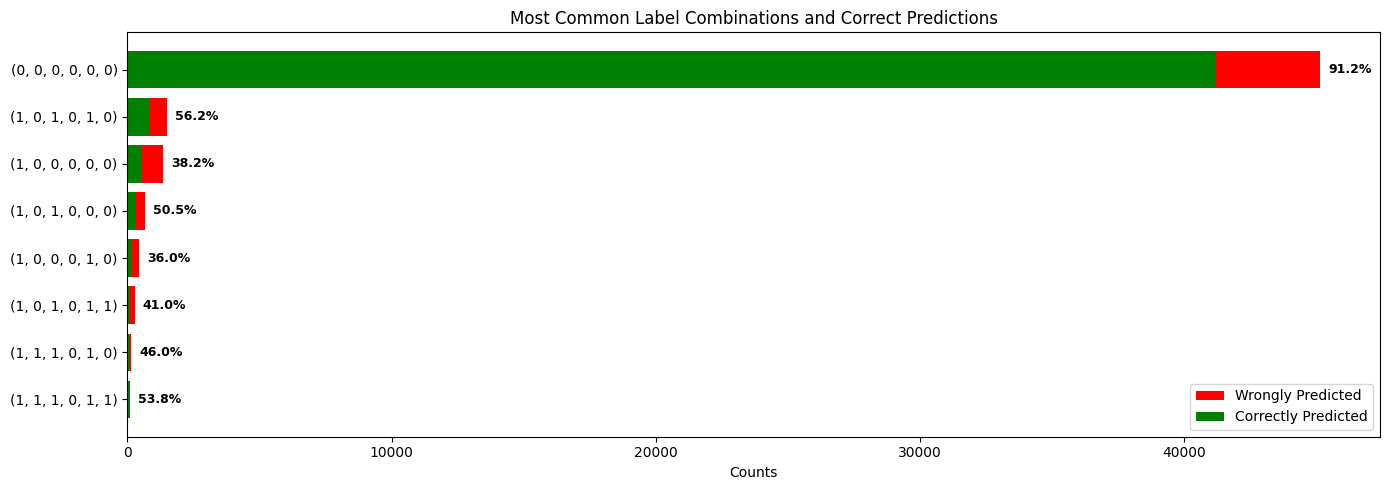

In [ ]:
true_label_tuples = [tuple(row) for row in true_labels_np]
pred_label_tuples = [tuple(row) for row in predicted_labels_np]

paired_labels = zip(true_label_tuples, pred_label_tuples)

label_counts = Counter(true_label_tuples)
correct_counts = Counter([true_label for true_label, pred_label
                          in paired_labels if true_label == pred_label])
common_labels = label_counts.most_common(8)
labels, counts = zip(*common_labels)

correct_label_counts = [correct_counts[label] if label
                        in correct_counts else 0 for label in labels]
correct_percentages = [(correct / total) * 100 for correct, total
                       in zip(correct_label_counts, counts)]

plt.figure(figsize=(14, 5))

bars = plt.barh(range(len(labels)), counts, color='red', label='Wrongly Predicted')
plt.barh(range(len(labels)), correct_label_counts, color='green', label='Correctly Predicted')

plt.yticks(range(len(labels)), labels)
plt.xlabel('Counts')
plt.title('Most Common Label Combinations and Correct Predictions')
plt.gca().invert_yaxis()

for bar, percentage in zip(bars, correct_percentages):
    plt.text(bar.get_width() + (0.025 * max(counts)),
             bar.get_y() + bar.get_height() / 2,
             f'{percentage:.1f}%',
             va='center',
             ha='center',
             color='black',
             fontsize=9,
             fontweight='bold')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In the test set, the most frequent labels are 'non-toxic' and 'toxic'. We also often see 'toxic' combined with 'obscene' and 'insult'.

The model could be enhanced to more accurately identify standalone 'toxic' labels. Better differentiation of non-toxic comments would also help.

Examples of comments that were misclassified:

In [ ]:
incorrectly_predicted_indices = np.where(np.any(test_df.iloc[:, 2:].values != predicted_labels_np, axis=1))[0]

incorrect_predictions_df = pd.DataFrame({
    'comment_text': test_df.iloc[incorrectly_predicted_indices]['comment_text'].values,
    'true_label': [test_df.iloc[i, 2:].tolist() for i in incorrectly_predicted_indices],
    'predicted_label': [predicted_labels_np[i].tolist() for i in incorrectly_predicted_indices]
})

incorrect_predictions_df.head(10)

,comment_text,true_label,predicted_label
0,""" \n ::::FUCK YOU! ""","[1, 0, 1, 0, 0, 0]","[1, 1, 1, 0, 1, 0]"
1,""" \n\n Emo is the new """"goth"""" to the musicall...","[0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
2,Cats pee are blue.,"[0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
3,:And your mother smells of elderberries! | .,"[1, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0]"
4,":::::It's generally unwise to behave stupidly,...","[0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 1, 0]"
5,== livian == \n\n livian sucks really bad!!!!...,"[1, 0, 1, 0, 1, 0]","[1, 0, 1, 0, 0, 0]"
6,== Ruined == \n\n What moron ruined this page ...,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 1, 0]"
7,== Tired of liars and manipulators == \n\n Use...,"[0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
8,I like you because you are smart. Are you black?,"[0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
9,:I was under the impression you were being van...,"[1, 0, 1, 0, 1, 1]","[1, 0, 0, 0, 0, 0]"


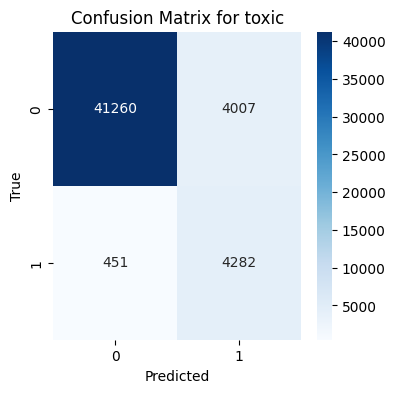

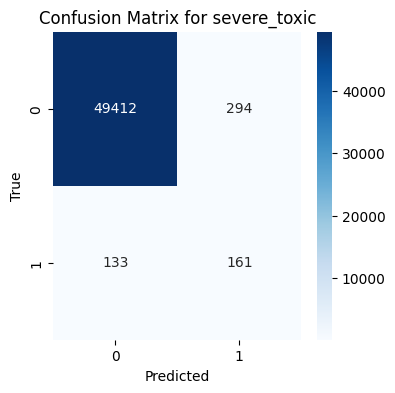

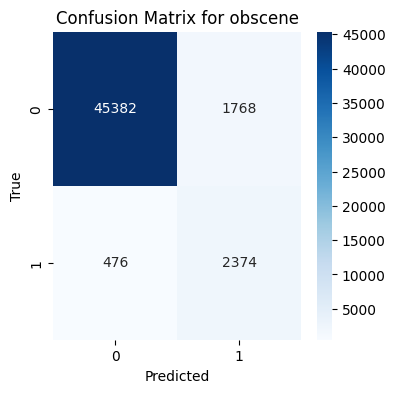

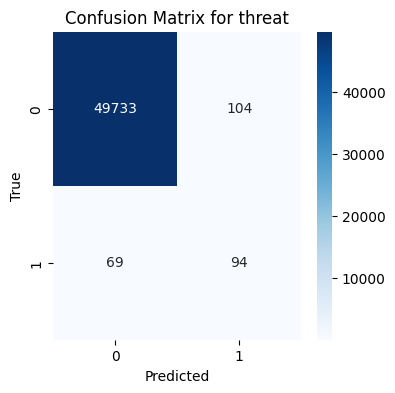

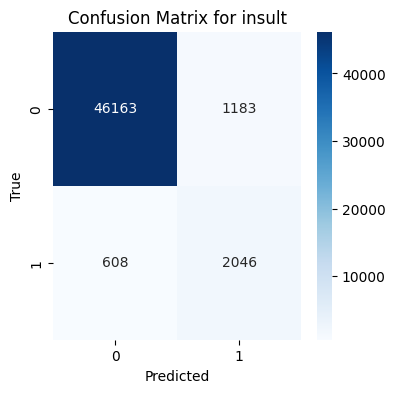

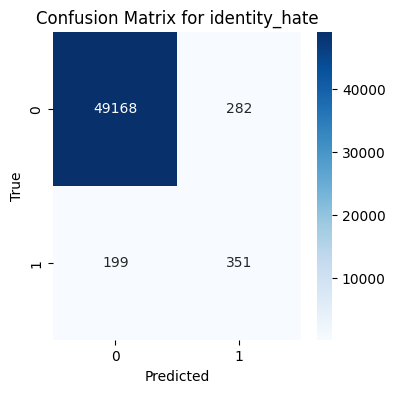

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in range(true_labels_np.shape[1]):
    preds = predicted_labels_np[:, i]
    truths = true_labels_np[:, i]

    cm = confusion_matrix(truths, preds)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'Confusion Matrix for {labels[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Summary
From the exploratory data analysis, several characteristics help distinguish between toxic and non-toxic labels, as well as among various levels of toxicity:
* Comment length
* Number of capital letters
* Number of exclamation marks
* Presence of swearwords in the comments

After implementing the hierarchical classification model using the RoBERTa pre-trained transformer, the best achieved mean column-wise ROC AUC score was 0.985. For comparison, the highest score on Kaggle for this task is 0.988.

## Potential Improvements:
* Fine-tune on a larger dataset
* Choose a different pre-trained transformer.
* Incorporate class weights to address data imbalance
* Conduct a more comprehensive search for optimal hyperparameters, such as learning rate, weight_decay, and optimizer type.